# __Сборный проект - 2__

# Введение

### Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

Изучите воронку продаж. Узнайте: 
- Как пользователи доходят до покупки. 
- Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. 

Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 
- 2 контрольные со старыми шрифтами 
- Одну экспериментальную — с новыми. 

Выясните, какой шрифт лучше.

### Описание данных

Каждая запись в логе — это действие пользователя, или событие. 
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# Ход работы

## Импорт необходимых библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import numpy as np
import math as mth
from scipy import stats as st
import warnings

warnings.filterwarnings('ignore')

## Предобработка данных

Сначала откроем датасет и рассмотрим его

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
df2 = df
df.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
print('Дубликатов:', df.duplicated().sum())

Дубликатов: 413


In [5]:
chech = df.groupby(by = 'DeviceIDHash').agg({'ExpId':'nunique'})
print('Пользователей, вошедших в обе группы:', len(chech[chech['ExpId'] != 1]))

Пользователей, вошедших в обе группы: 0


In [6]:
df.groupby(by = 'ExpId').agg({'DeviceIDHash':'count'})

,DeviceIDHash
ExpId,
246,80304
247,78075
248,85747


Группы примерно равны по численности. С этим все хорошо

На основании этих данных можно сказать, что необходимо:
- Поменять названия колонок
- Изменить тим данных столбца EventTimestamp на timestamp
- Добавить сепарированный столбец даты
- Удалить дубликаты

Приступим:

In [7]:
df.columns = ['event_name', 'user_id', 'datetime', 'group']
df['datetime'] = pd.to_datetime(df['datetime'], unit='s') 
df['date'] = df['datetime'].dt.date
df['date'] = pd.to_datetime(df['date'])
df = df.drop_duplicates().reset_index(drop=True)
df.head(5)

,event_name,user_id,datetime,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


На этом первичную обработку данных будем считать завершенной.

Проверим данные на наличие пропусков:

In [8]:
df.isna().sum()

event_name    0
user_id       0
datetime      0
group         0
date          0
dtype: int64

Данные целы, убирать пустые или полупустые строчки не нужно.

In [9]:
events = df.groupby(by = 'date').agg({'event_name':'count'})
user_activity = df.groupby(by = 'user_id').agg({'event_name':'count'})

Получим общие данные о количистве пользователей, промежутке времени и числе событий

In [10]:
user_activity = df.groupby(by = 'user_id').agg({'event_name':'count'})
print('Представлены логи за период с', min(df['datetime']), 'по', max(df['datetime']), 
      '\nВсего событий за период:' ,events['event_name'].sum(),
     '\nУникальных пользователей:', df['user_id'].nunique(),
     '\nНа пользователя в среднем приходится', user_activity['event_name'].median().round(), 'событий')

Представлены логи за период с 2019-07-25 04:43:36 по 2019-08-07 21:15:17 
Всего событий за период: 243713 
Уникальных пользователей: 7551 
На пользователя в среднем приходится 20.0 событий


Выясним 

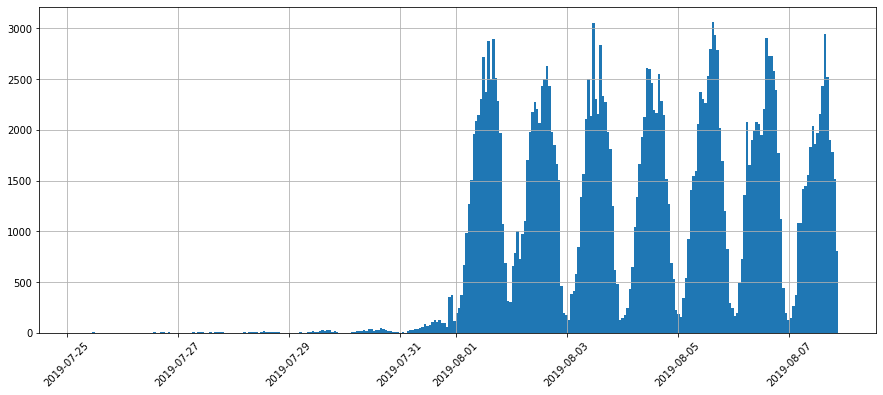

In [11]:
plt.figure(figsize = (15, 6))
ax = df['datetime'].hist(bins=312)
plt.xticks(rotation=45)
plt.show;

Согласно данным, полученным из гистограммы, равные данные им имеем только с 2019-08-01 по 2019-08-07. При том для удобства началом изучаемого отрезка будем считать метку 2019-08-01 00:07:28, а концом 2019-08-07 21:15:17 

"Обрежу" данные и выведу гистограмму с разбиением на группы:

In [12]:
df = df[df['date'] >= '2019-08-01']
user_activity = df.groupby(by = 'user_id').agg({'event_name':'count'})
print('В данных уточненного периода представлены логи за период с', min(df['datetime']), 'по', max(df['datetime']), 
      '\nВсего событий за период:' ,events['event_name'].sum(),
     '\nУникальных пользователей:', df['user_id'].nunique(),
     '\nНа пользователя в среднем приходится', user_activity['event_name'].median().round(), 'событий')

В данных уточненного периода представлены логи за период с 2019-08-01 00:07:28 по 2019-08-07 21:15:17 
Всего событий за период: 243713 
Уникальных пользователей: 7534 
На пользователя в среднем приходится 19.0 событий


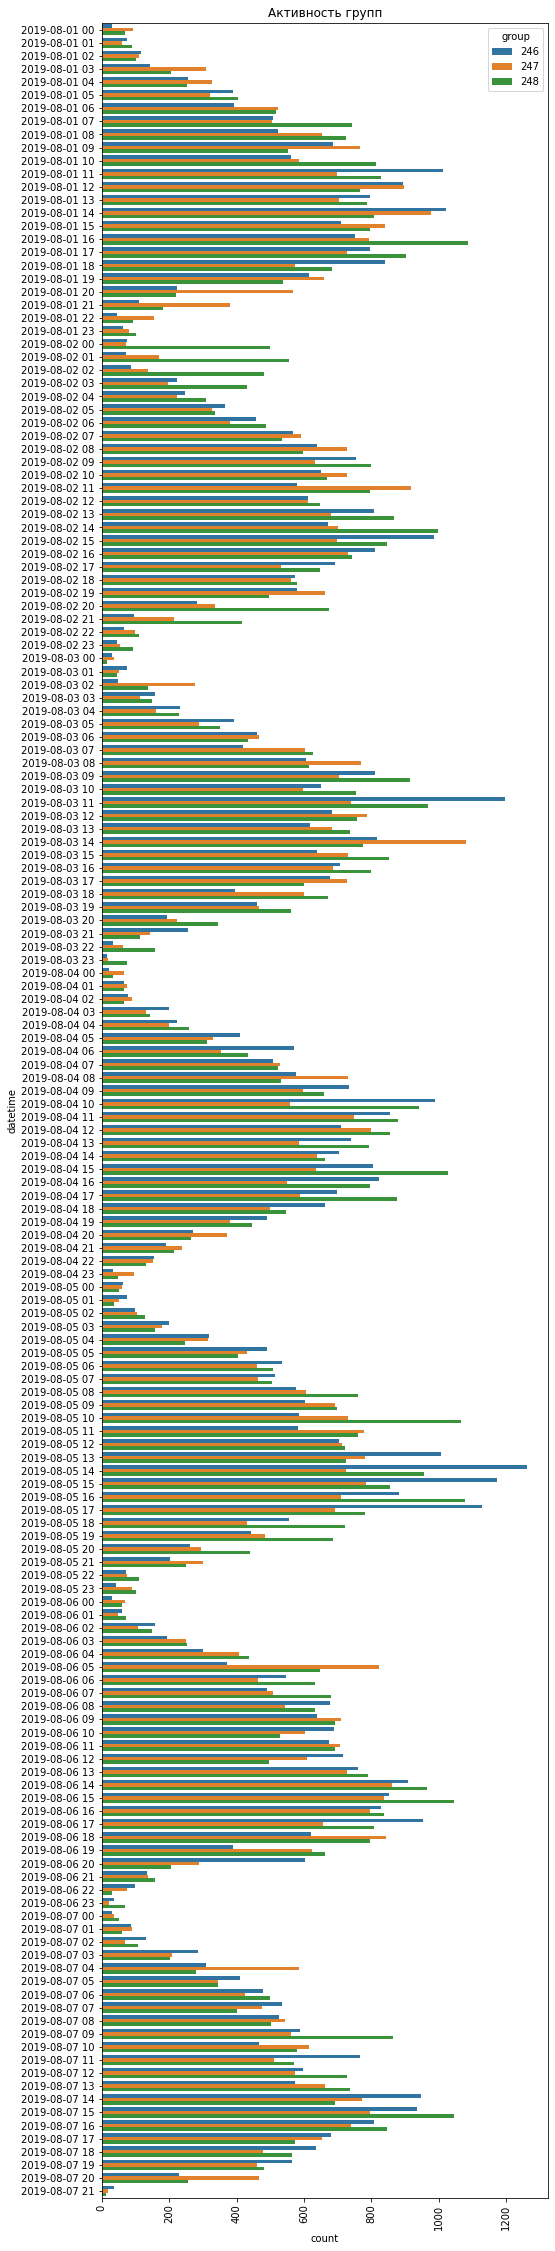

In [13]:
plt.figure(figsize=(8, 40))
ax = sns.countplot(y=df['datetime'].dt.strftime('%Y-%m-%d %H'),  data=df, hue='group')
plt.xticks(rotation=90)
ax.set_title('Активность групп')
plt.show;

Рассчитаем потери данных:

In [14]:
print('Потеряно', round(((1 - len(df) / len(df2))*100), 2), '% событий')
print('Потеряно', round(df2['user_id'].nunique() / df['user_id'].nunique(), 2), '% уникальных пользователей')

Потеряно 1.33 % событий
Потеряно 1.0 % уникальных пользователей


Потери данных о событиях и уникальных пользователях составили менее 1.5% от исходного их числа. Также по гистограмме видно, что в ней примерно в равной степени представлены все три группы. Такие данные будем считать полностью очищенными и на их основе будем строить предположнния и выводы

## Анализ воронки событий

Для начала изучим как часто какое событие встречается. Для визуального представления используем гистограмму

,event_name,user_id
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


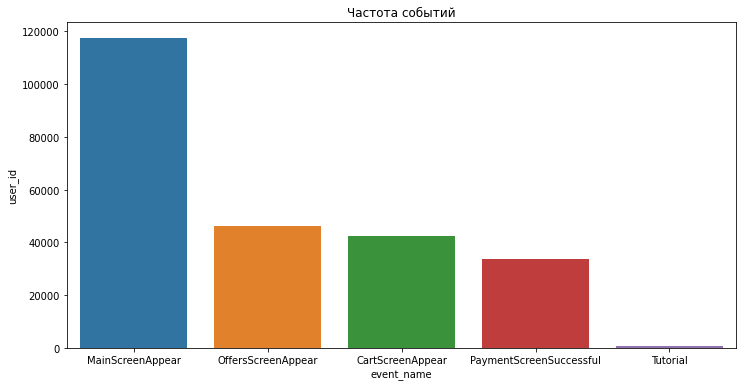

In [15]:
plt.figure(figsize=(12, 6))
ax = df.groupby(by = 'event_name').agg({'user_id':'count'}).sort_values(by = 'user_id', ascending = False).reset_index()
gg = sns.barplot(data = ax,  x = 'event_name', y = 'user_id')
gg.set_title('Частота событий');
ax

А вот частота событий по группам. Как видно, аномальных различий нет.

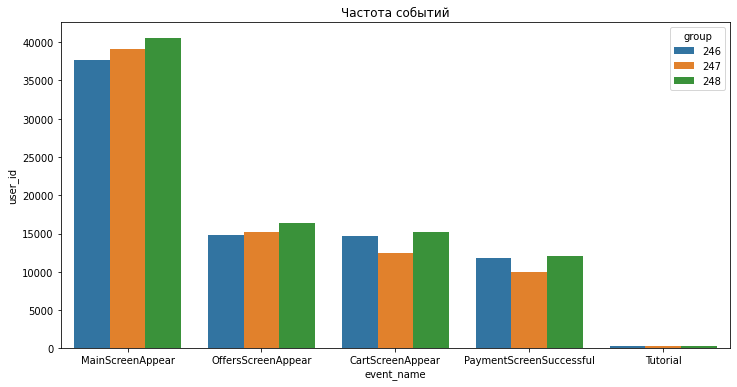

In [17]:
plt.figure(figsize=(12, 6))
ax = df.groupby(by = ['event_name', 'group']).agg({'user_id':'count'}).sort_values(by = 'user_id', ascending = False).reset_index()
ax2 = ax
gg = sns.barplot(data = ax,  x = 'event_name', y = 'user_id', hue = 'group')
gg.set_title('Частота событий');

Теперь выясним сколько людей прошли через все шаги, т.е составим "воронку"

In [18]:
ax = df.groupby(by = ['user_id', 'event_name']).nunique()
voronka = ax.reset_index(level=1).index.value_counts()
print('Число пользователей, совершивших все отслеживаемые действия:', len(voronka[voronka == 5]))

Число пользователей, совершивших все отслеживаемые действия: 466


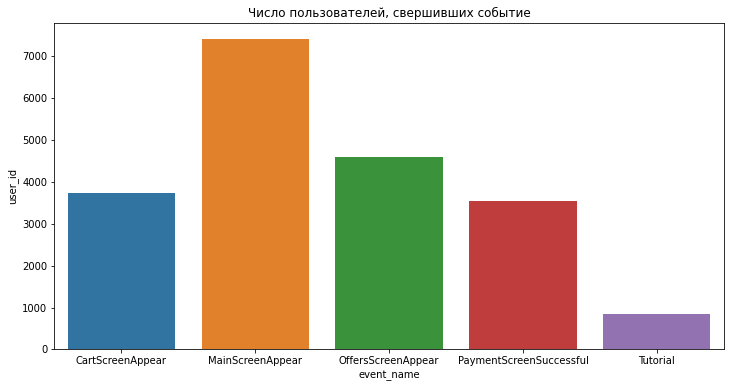

In [19]:
plt.figure(figsize=(12, 6))
distribution = df.groupby(by = 'event_name').agg({'user_id':'nunique'}).reset_index()
distribution2 = distribution
distribution['ratio'] = distribution['user_id'] / df['user_id'].nunique()
ax = sns.barplot(data = distribution, x = 'event_name', y = 'user_id')
ax.set_title('Число пользователей, свершивших событие');

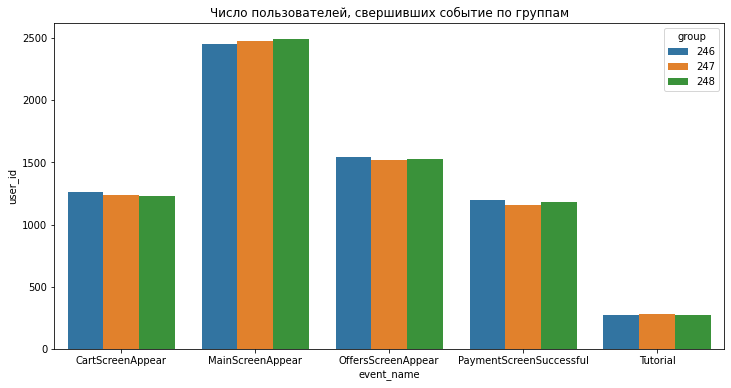

In [20]:
plt.figure(figsize=(12, 6))
distribution = df.groupby(by = ['event_name', 'group']).agg({'user_id':'nunique'}).reset_index()
distribution['ratio'] = distribution['user_id'] / df['user_id'].nunique()
ax = sns.barplot(data = distribution, x = 'event_name', y = 'user_id', hue = 'group')
ax.set_title('Число пользователей, свершивших событие по группам');

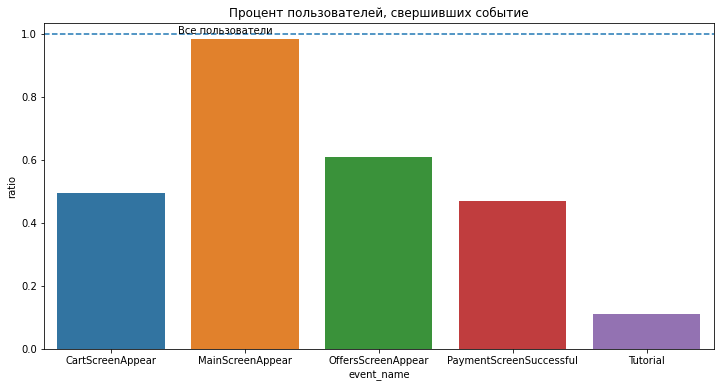

In [21]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data = distribution2, x = 'event_name', y = 'ratio')
ax.axhline(1, ls='--')
ax.text(0.5,1, "Все пользователи")
ax.set_title('Процент пользователей, свершивших событие');

Опираясь на данные, полученные из гистограммы выше, можно предположить, что с пользователем происходят события в средующем порядке:
- ↓ Пользователь видит главный экран (**MainScreenAppear**)
- ↓ Пользователь видит экран каталога (**OfferScreenAppear**)
- ↓ Пользователь добавляет товар в корзину и заходит в нее (**CartScreenOpen**)
- ↓ Пользователь оплачивает и видит экран подтверждения его заказа (**PaymentScreenSuccessful**)

Также он может в необязательном порядке открыть руководство (**Tutorial**), однако мало кто этим пользуется

Предполагая, что воронка исключает возможность совершения пользователем вышеуказанных действий в ином порядке, расчитаем конверсию между шагами

In [22]:
conversion = df.groupby(by = 'event_name').agg({'user_id':'nunique'})[:4].sort_values(by = 'user_id', ascending = False).reset_index()
conversion['Потери пользователей после предыдущего шага в %'] = (1-(conversion['user_id'] / conversion['user_id'].shift(1)))*100
conversion['Доля от всех пользователей'] = conversion['user_id'] / conversion['user_id'][0]
conversion

,event_name,user_id,Потери пользователей после предыдущего шага в %,Доля от всех пользователей
0,MainScreenAppear,7419,NaN,1.000000
1,OffersScreenAppear,4593,38.091387,0.619086
2,CartScreenAppear,3734,18.702373,0.503302
3,PaymentScreenSuccessful,3539,5.222282,0.477018


**Промежуточные итоги:**

- Почти 40% пользователей не открывают каталог.
- Всего покупку успешно оплачивают 47% пользователй, что открывают приложение. Вообще-то это отличный результат!

## Изучение результатов эксперемента

Изучим сколько пользователей в каждой группе:

In [23]:
ax = df.groupby(by = 'group').agg({'user_id':'nunique'})[:3]
ax

,user_id
group,
246,2484
247,2513
248,2537


Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247:

**Критерии успешного A/A-теста:**
- Количество пользователей в различных группах различается не более, чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

Несомненно, можно согласится с пунктами 2 и 4. Проверим, верны ли в нашем случае пункты 1 и 3. Для этого создам удобную функцию:

In [24]:
def statmat(counterpart1, counterpart2):
    qq = df.groupby(['event_name', 'group']).agg({'user_id':'nunique'}).reset_index()
    qq = qq[((qq['group'] == counterpart1) | (qq['group'] == counterpart2)) & (qq['event_name']!='Tutorial')]
    alpha = 0.05
    event_names = ['CartScreenAppear','MainScreenAppear','OffersScreenAppear','PaymentScreenSuccessful']  
    for entry in event_names:
        unique_users_event = np.array([qq[(qq['event_name'] == entry) & (qq['group'] == counterpart1)]['user_id'], 
                               qq[(qq['event_name'] == entry) & (qq['group'] == counterpart2)]['user_id']])
        unique_users_group = np.array([ax[ax.index == counterpart1]['user_id'], ax[ax.index == counterpart2]['user_id']])
        p1 = unique_users_event[0]/unique_users_group[0]
        p2 = unique_users_event[1]/unique_users_group[1]
        p_combo = (unique_users_event[0] + unique_users_event[1]) / (unique_users_group[0] + unique_users_group[1])
        difference = p1 - p2
        z_value = difference / mth.sqrt(p_combo * (1 - p_combo) * (1/unique_users_event[0] + 1/unique_users_event[1]))
        distr = st.norm(0, 1)  
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('p-значение: ', p_value)
        print('Event: ', entry)
        if p_value < alpha:
            print('Между долями есть значимая разница')
        else:
            
            print('Нет оснований считать доли разными')
        print('')

Проведем A1/A2 тестирование:

In [25]:
statmat(246, 247)

p-значение:  [0.3943211]
Event:  CartScreenAppear
Нет оснований считать доли разными

p-значение:  [0.75873715]
Event:  MainScreenAppear
Нет оснований считать доли разными

p-значение:  [0.36593695]
Event:  OffersScreenAppear
Нет оснований считать доли разными

p-значение:  [0.27844013]
Event:  PaymentScreenSuccessful
Нет оснований считать доли разными



По итогам A/A тестирования статистически значимой разницы между выборками группы 246 и 247 **НЕТ**. На них можно опираться. Это касается **ВСЕХ** событий, в т.ч. и самого популярного (MainScreenAppear)

Поступлю аналогично с группой с измененным шрифтом. Сравню с каждой из контрольных групп в отдельности:

In [26]:
statmat(246, 248)

p-значение:  [0.21469452]
Event:  CartScreenAppear
Нет оснований считать доли разными

p-значение:  [0.29874503]
Event:  MainScreenAppear
Нет оснований считать доли разными

p-значение:  [0.32498018]
Event:  OffersScreenAppear
Нет оснований считать доли разными

p-значение:  [0.39033692]
Event:  PaymentScreenSuccessful
Нет оснований считать доли разными



In [27]:
statmat(247, 248)

p-значение:  [0.69781422]
Event:  CartScreenAppear
Нет оснований считать доли разными

p-значение:  [0.46232865]
Event:  MainScreenAppear
Нет оснований считать доли разными

p-значение:  [0.93760629]
Event:  OffersScreenAppear
Нет оснований считать доли разными

p-значение:  [0.81946233]
Event:  PaymentScreenSuccessful
Нет оснований считать доли разными



Как можно увидеть, значимой разницы в поведении пользователей в группах со старым и новым шрифтом не наблюдается. Для чистоты эксперемента проведем тот же эксперемент в отношении объединенной контрольной и эксперементальной групп:

In [28]:
qq = df.groupby(['event_name', 'group']).agg({'user_id':'nunique'}).reset_index()
qq = qq[((qq['group'] == 246) | (qq['group'] == 247)) & (qq['event_name']!='Tutorial')]
qq = qq.groupby(by = 'event_name').agg({'user_id':'sum'}).reset_index()
qq['group'] = 1
sq = df.groupby(['event_name', 'group']).agg({'user_id':'nunique'}).reset_index()
sq = sq[((sq['group'] == 248)) & (sq['event_name']!='Tutorial')]
ana = pd.concat([qq, sq])
qq = ana
ax = df.groupby(by = 'group').agg({'user_id':'nunique'})
ax = ax.reset_index()
ax.loc[3] = [1, ax['user_id'][0] + ax['user_id'][1]]
ax = ax[2:4]
counter = 0
counterpart1 = 1
counterpart2 = 248
alpha = 0.05
event_names = ['CartScreenAppear','MainScreenAppear','OffersScreenAppear','PaymentScreenSuccessful']  
for entry in event_names:
    unique_users_event = np.array([qq[(qq['event_name'] == entry) & (qq['group'] == counterpart1)]['user_id'], 
                               qq[(qq['event_name'] == entry) & (qq['group'] == counterpart2)]['user_id']])
    unique_users_group = np.array([ax[ax['group'] == counterpart1]['user_id'], ax[ax['group'] == counterpart2]['user_id']])
    p1 = unique_users_event[0]/unique_users_group[0]
    p2 = unique_users_event[1]/unique_users_group[1]
    p_combo = (unique_users_event[0] + unique_users_event[1]) / (unique_users_group[0] + unique_users_group[1])
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combo * (1 - p_combo) * (1/unique_users_event[0] + 1/unique_users_event[1]))
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    print('Event: ', entry)
    if p_value < alpha:
        print('Между долями есть значимая разница')
    else:        
        print('Нет оснований считать доли разными')
    print('')

p-значение:  [0.3498249]
Event:  CartScreenAppear
Нет оснований считать доли разными

p-значение:  [0.29821162]
Event:  MainScreenAppear
Нет оснований считать доли разными

p-значение:  [0.54253313]
Event:  OffersScreenAppear
Нет оснований считать доли разными

p-значение:  [0.72020578]
Event:  PaymentScreenSuccessful
Нет оснований считать доли разными



In [29]:
#Уважаемый ревьюер, я понимаю, что код тут отвратительно неоптимизированный. 
#Возможно, вы могли бы дать мне парочку советов как сделать его лучше и использовать уже написанную мною ранее функцию?

Как можно увидеть, сравнение результатов эксперементальной и объединенной контрольной группы не дало нам иных результатов. Статистически значимой разницы в показателях **НЕТ**

## Вывод

По ходу работы была проведена первичная обработка данных. В том числе были отброшены данные до 2019-08-01 00:07:28


Было установлено, что до экрана каталога добралось чуть больше половины пользователей, однако большая их часть совершила покупку. Поэтому можно рекомендовать:
- Сделать каталог более заметным
- Переработать дизайн главного экрана, чтобы он был менее отталкивающим
- Добавить фрагмент каталога прямо на главный экран (например раздел "Популярное" или "Вас может заинтересовать")


Было доказано, что группы испытуемых равновесны и подходят для проведения A/A/B тестирования.

В результате 16 испытаний, включавших в себя A/A, A1/B, A2/B и A1+A2/B тестирование было выяснено, что ни по одному из отслеживаемых событий в каждом из тестов нет статистически значимой разницы в результатах.

В описанных выше тестах уровень значимости был задан как alpha = 0.05. Это должно быть достаточным для поставленных нами задач.


Также, основываясь на проведенных до этого тестированиях, можно заявлять, что изменение шрифта в приложении не оказывает значительного влияния на поведение пользователей, так что его можно и поменять не опасаясь негативных последствий для бизнеса. 